# Introduction

For this exercise, we will attempt to train a classifier that can tell the difference between healthy and diseased plants by processing images of their leaves. We will use the 'PlantVillage' dataset (source: [Kaggle](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset))

One option would be to have the model identify each different class separately, but this would necessitate that it simultaneously understands what plant a leaf comes from as well as what disease it might have. However, identifying plants from their leaves is an extra challenge that is beyond the scope of what we are trying to do here, and it would also have the effect of limiting the model's capabilities to the handful of plant species it was exposed to.

Another option would be to split the dataset into two classes, healthy and sick. This would likely give good results, but one might well have cause to question the overall usefulness of a classifier that will tell you a plant is sick but cannot as much as venture a guess with regard to what is causing the sickness.

Instead what we will do is group the diseases together, across plants, and hopefully train a model that can identify them even when it comes across an unknown species.

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 13.2 MB/s 


In [ ]:
! mkdir ~/.kaggle
! echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'abdallahalidev/plantvillage-dataset'
! unzip -q /content/plantvillage-dataset.zip

 99% 2.03G/2.04G [01:07<00:00, 42.4MB/s]
100% 2.04G/2.04G [01:07<00:00, 32.3MB/s]


In [ ]:
import os
from os import listdir, path
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
import keras_tuner as kt
%matplotlib inline

# Preprocessing

The dataset is split along directories, each of a combination of a plant and a disease (or 'healthy' for plants not afflicted with a disease). The full list of diseases, including healthy, has been hardcoded below.

In [ ]:
class_names = ['Apple_scab', 'Bacterial_spot', 'Black_rot', 'Cedar_apple_rust', 'Cercospora_leaf_spot Gray_leaf_spot', \
               'Common_rust_', 'Early_blight', 'Esca_(Black_Measles)', 'Haunglongbing_(Citrus_greening)', 'Late_blight', \
               'Leaf_Mold', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'Leaf_scorch', 'Northern_Leaf_Blight', 'Powdery_mildew', \
               'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', \
               'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']

In [ ]:
one_hot = lambda label: [1 if class_names.index(label)==i else 0 for i in range(len(class_names))]

In [ ]:
#dataset_path='/media/victor/hdd/datasets/plant_diseases/big'
dataset_path='/content/plantvillage dataset/color'
plants=dict()
images=list()
labels=list()
for dir_name in listdir(dataset_path):
    (plant,disease)=dir_name.split('___')

    if plant not in plants:
        plants[plant]=[disease]
    else:
        plants[plant].append(disease)

    new_images = [os.path.join(dataset_path,dir_name,file_name) for file_name in listdir(os.path.join(dataset_path,dir_name))]
    images += new_images
    labels += [one_hot(disease) for i in range(len(new_images))]

In [ ]:
classes_df=pd.DataFrame([[i,labels.count(one_hot(i))] for i in class_names], columns=['class_name', 'sample_count'])

In [ ]:
classes_df.sort_values('sample_count')

,class_name,sample_count
19,Tomato_mosaic_virus,226
3,Cedar_apple_rust,275
4,Cercospora_leaf_spot Gray_leaf_spot,513
0,Apple_scab,630
10,Leaf_Mold,952
13,Northern_Leaf_Blight,985
11,Leaf_blight_(Isariopsis_Leaf_Spot),1076
12,Leaf_scorch,1109
5,Common_rust_,1192
7,Esca_(Black_Measles),1383


In [ ]:
classes_df.describe()

,sample_count
count,21.000000
mean,2394.761905
std,2925.499580
min,226.000000
25%,985.000000
50%,1404.000000
75%,2887.000000
max,13493.000000


It can be seen that our classes are heavily unbalanced, with the biggest being nearly 60 times bigger than the smallest one. For our first run, in order to tune the model, we will work with a smaller subset of our dataset. We are going to use random undersampling to bring the number of samples of all of the classes closer to that of the smallest one.

In [ ]:
cutoff=226
num_samples={label:
             cutoff+(classes_df['sample_count'].iloc[label]-cutoff)//20 if classes_df['sample_count'].iloc[label]>cutoff
             else classes_df['sample_count'].iloc[label]
             for label in classes_df.index}

In [ ]:
sampler = RandomUnderSampler(sampling_strategy=num_samples, random_state=1020034)
balanced_images, balanced_labels = sampler.fit_resample(np.array(images).reshape(-1,1),np.array(labels))

In [ ]:
train_val_images, test_images, train_val_labels, test_labels = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=1020034, stratify=balanced_labels)

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size=0.25, random_state=1020034, stratify=train_val_labels)

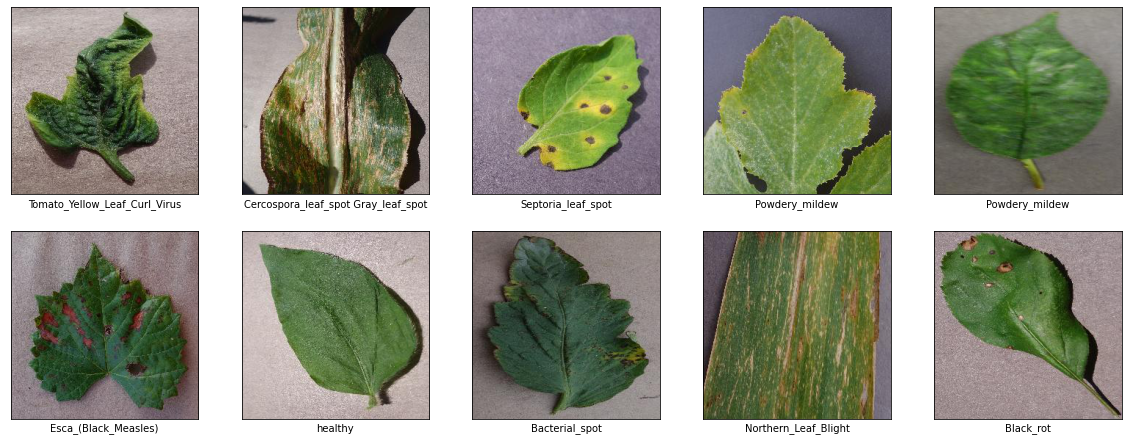

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_images[i][0]
    plt.xlabel(class_names[np.argmax(train_labels[i])])
    img = plt.imread(path)
    plt.imshow(img)

## Dataset from list

Since the full dataset is too big too fit into memory, we elected to make use of tensorflow's data API to build a pipeline that can fetch the images from disk at the moment they are needed. This provides some utility, but also some drawbacks that will have to be worked around. One of those is the difficulty in doing the stratified train-test-validation split or the undersampling after the dataset has been created, which is why that was done above. We are going to set the batch size here, which is also the one we will use for our model, and also set up the dataset to prefetch two batches at a time, so that the training is not throttled due to a bottleneck in retrieving the images from the disk, which can be done in parallel.

In [ ]:
batch_size=128
prefetch=2

In [ ]:
def prepare_dataset(ds):
    load_image = lambda x,y: (tf.io.read_file(x[0]), y)
    decode_image = lambda x,y: (tf.io.decode_jpeg(x, channels=3), y)
    ds = ds.map(load_image).map(decode_image).batch(batch_size).prefetch(prefetch)
    return ds

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
val_ds=tf.data.Dataset.from_tensor_slices((val_images,val_labels))
train_ds=prepare_dataset(train_ds)
val_ds=prepare_dataset(val_ds)

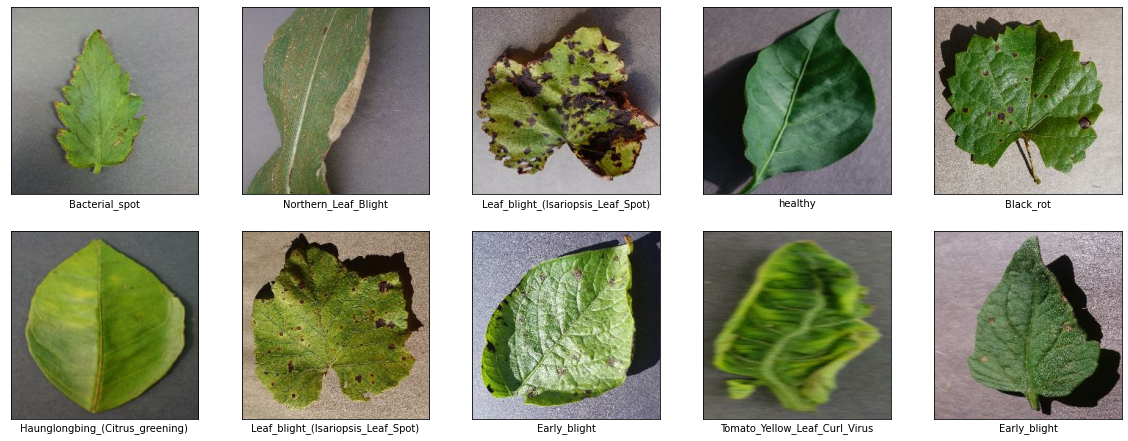

In [ ]:
for image_batch, label_batch in train_ds.take(1):
    pass
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[np.argmax(label_batch[i+10])])
    plt.imshow(image_batch[i+10])

The rest of the preprocessing on the images can be done as part of the dataset pipeline. We will define the operations we want here, and include them as part of the model.

## Transform

The first of those operations will be to resize the images to 128x128 pixels for better performance, and normalize the pixels' values into floating points with values from 0 to 1.

In [ ]:
image_size=128

In [ ]:
transform = Sequential([
    layers.Input(shape=(image_size, image_size, 3)),
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
])

## Data augmentation

We will also include data augmentation layers, for slight rotations and zoom, as well as vertical and horizontal flip. While included in the model, these layers will only be active during training and will have no effect on the test data.

In [ ]:
augment = Sequential([
    layers.Input(shape=(image_size, image_size, 3)),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomFlip()
])

# Prediction

## Benchmark

In order to have a reference, we will first manually create and train a simple benchmark model.

In [ ]:
def create_benchmark_model():
    benchmark_model = Sequential([
        transform,
        augment,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    return benchmark_model

In [ ]:
benchmark_model=create_benchmark_model()

benchmark_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.005, patience=5, restore_best_weights=True)

In [ ]:
%%time
benchmark_history = benchmark_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40
34/34 [==============================] - 5s 125ms/step - loss: 2.7269 - accuracy: 0.2017 - val_loss: 2.2438 - val_accuracy: 0.2869
Epoch 2/40
34/34 [==============================] - 4s 126ms/step - loss: 2.0556 - accuracy: 0.3433 - val_loss: 1.7795 - val_accuracy: 0.4414
Epoch 3/40
34/34 [==============================] - 4s 106ms/step - loss: 1.6738 - accuracy: 0.4640 - val_loss: 1.5353 - val_accuracy: 0.5198
Epoch 4/40
34/34 [==============================] - 4s 105ms/step - loss: 1.4228 - accuracy: 0.5423 - val_loss: 1.3342 - val_accuracy: 0.5724
Epoch 5/40
34/34 [==============================] - 4s 108ms/step - loss: 1.2502 - accuracy: 0.5968 - val_loss: 1.4071 - val_accuracy: 0.5461
Epoch 6/40
34/34 [==============================] - 4s 112ms/step - loss: 1.1453 - accuracy: 0.6280 - val_loss: 1.2785 - val_accuracy: 0.5800
Epoch 7/40
34/34 [==============================] - 4s 112ms/step - loss: 1.0354 - accuracy: 0.6636 - val_loss: 1.1346 - val_accuracy: 0.6292
Epoch 

With a validation accuracy of 0.7, that's not particularly bad. We'll see if we can improve it.

## Bayesian hyperparameter search

We are going to use a Bayesian search, as implemented by the Keras Tuner API, in order to find the best hyperparameters for our model. Unfortunately, Keras Tuner currently does not have support for K-Fold cross-validation, so each model will be run once (on the train and validation sets created above).

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(transform)
    model.add(augment)

    conv_layers=4
    activation='relu'#hp.Choice('activation', ['relu'])
    dense_units=hp.Int('dense_units', 16, 256, sampling='log')
    learning_rate=hp.Float('learning_rate', 0.0005, 0.1, sampling='log')
    decay_rate=hp.Float('decay_rate', 0.0001, 1.0, sampling='log')
    units=list(range(conv_layers))
    dropout_rate=list(range(conv_layers))

    for i in range(conv_layers):
        units[i]=hp.Int(f'conv{i}_units', 16, 256, sampling='log')
        dropout_rate[i]=hp.Float(f'dropout_rate{i}', 0.0, 0.9, step=0.05)

    model.add(layers.Conv2D(units[i], 3, padding='same', activation=activation))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate[i]))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(units[i], 3, padding='same', activation=activation))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate[i]))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(units[i], 3, padding='same', activation=activation))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate[i]))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(units[i], 3, padding='same', activation=activation))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate[i]))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.Dense(len(class_names), activation='softmax'))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=decay_rate)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

In [ ]:
tuner=kt.BayesianOptimization(hypermodel=create_model, objective='val_accuracy', directory='/content/runs', project_name='run4', max_trials=100)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.005, patience=3, restore_best_weights=True)

In [ ]:
%%time
tuner.search(train_ds, validation_data=val_ds, epochs=6, batch_size=batch_size, callbacks=[early_stopping])

Trial 100 Complete [00h 00m 34s]
val_accuracy: 0.1621621549129486

Best val_accuracy So Far: 0.514899492263794
Total elapsed time: 01h 53m 07s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 50min 58s, sys: 14min 59s, total: 2h 5min 57s
Wall time: 1h 51min 5s


After a couple of hours and 100 different models, these are the results:

In [ ]:
tuner.results_summary()

Results summary
Results in ./run2
Showing 10 best trials
Trial summary
Hyperparameters:
dense_units: 78
learning_rate: 0.017803529179393856
decay_rate: 0.00015834182527950852
conv0_units: 99
dropout_rate0: 0.9
conv1_units: 16
dropout_rate1: 0.15000000000000002
conv2_units: 173
dropout_rate2: 0.6000000000000001
conv3_units: 16
dropout_rate3: 0.2
Score: 0.514899492263794
Trial summary
Hyperparameters:
dense_units: 94
learning_rate: 0.026221079773617557
decay_rate: 0.0003882216464931427
conv0_units: 93
dropout_rate0: 0.9
conv1_units: 19
dropout_rate1: 0.15000000000000002
conv2_units: 156
dropout_rate2: 0.55
conv3_units: 17
dropout_rate3: 0.25
Score: 0.45668745040893555
Trial summary
Hyperparameters:
dense_units: 90
learning_rate: 0.02611900243118304
decay_rate: 0.0001736854722606504
conv0_units: 112
dropout_rate0: 0.9
conv1_units: 16
dropout_rate1: 0.1
conv2_units: 198
dropout_rate2: 0.6000000000000001
conv3_units: 17
dropout_rate3: 0.25
Score: 0.3915453851222992
Trial summary
Hyperparame

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]

In [ ]:
best_hp.values

{'conv0_units': 99,
 'conv1_units': 16,
 'conv2_units': 173,
 'conv3_units': 16,
 'decay_rate': 0.00015834182527950852,
 'dense_units': 78,
 'dropout_rate0': 0.9,
 'dropout_rate1': 0.15000000000000002,
 'dropout_rate2': 0.6000000000000001,
 'dropout_rate3': 0.2,
 'learning_rate': 0.017803529179393856}

The accuracy is not great, only 0.5, although the models were stopped after just 6 epochs to save time. We can build a model using the best hyperparameters and let it run for longer:

In [ ]:
best_model=tuner.hypermodel.build(best_hp)

In [ ]:
best_history=best_model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/50
34/34 [==============================] - 7s 121ms/step - loss: 2.4619 - accuracy: 0.2632 - val_loss: 13.0202 - val_accuracy: 0.1379
Epoch 2/50
34/34 [==============================] - 3s 101ms/step - loss: 1.8236 - accuracy: 0.4050 - val_loss: 9.9739 - val_accuracy: 0.1629
Epoch 3/50
34/34 [==============================] - 3s 100ms/step - loss: 1.4897 - accuracy: 0.5173 - val_loss: 7.7091 - val_accuracy: 0.1705
Epoch 4/50
34/34 [==============================] - 3s 100ms/step - loss: 1.3437 - accuracy: 0.5555 - val_loss: 4.1440 - val_accuracy: 0.2543
Epoch 5/50
34/34 [==============================] - 5s 135ms/step - loss: 1.2026 - accuracy: 0.5954 - val_loss: 3.0141 - val_accuracy: 0.3125
Epoch 6/50
34/34 [==============================] - 5s 135ms/step - loss: 1.1522 - accuracy: 0.6165 - val_loss: 1.9208 - val_accuracy: 0.4463
Epoch 7/50
34/34 [==============================] - 4s 129ms/step - loss: 1.0685 - accuracy: 0.6483 - val_loss: 3.3265 - val_accuracy: 0.3382
Epoch

We'll also try after tuning the hyperparameters into more conventional values:

In [ ]:
tuned_hp=best_hp.copy()

In [ ]:
tuned_hp.values= \
{'conv0_units': 128,
 'conv1_units': 16,
 'conv2_units': 256,
 'conv3_units': 16,
 'decay_rate': 0.0002,
 'dense_units': 128,
 'dropout_rate0': 0.9,
 'dropout_rate1': 0.15,
 'dropout_rate2': 0.6,
 'dropout_rate3': 0.2,
 'learning_rate': 0.02}

In [ ]:
model=tuner.hypermodel.build(tuned_hp)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/50
34/34 [==============================] - 6s 119ms/step - loss: 2.8610 - accuracy: 0.2703 - val_loss: 81.1979 - val_accuracy: 0.0499
Epoch 2/50
34/34 [==============================] - 3s 97ms/step - loss: 1.8208 - accuracy: 0.4254 - val_loss: 15.3058 - val_accuracy: 0.1795
Epoch 3/50
34/34 [==============================] - 3s 98ms/step - loss: 1.4966 - accuracy: 0.5060 - val_loss: 9.7055 - val_accuracy: 0.1982
Epoch 4/50
34/34 [==============================] - 4s 116ms/step - loss: 1.3272 - accuracy: 0.5668 - val_loss: 7.4252 - val_accuracy: 0.2093
Epoch 5/50
34/34 [==============================] - 4s 113ms/step - loss: 1.1967 - accuracy: 0.5994 - val_loss: 5.6946 - val_accuracy: 0.2495
Epoch 6/50
34/34 [==============================] - 4s 112ms/step - loss: 1.1201 - accuracy: 0.6322 - val_loss: 5.3600 - val_accuracy: 0.2176
Epoch 7/50
34/34 [==============================] - 4s 109ms/step - loss: 1.0381 - accuracy: 0.6578 - val_loss: 4.9354 - val_accuracy: 0.3056
Epoch 

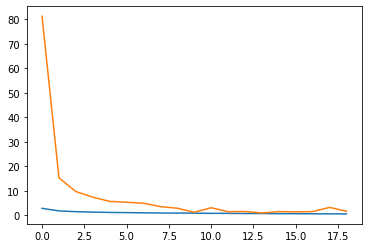

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

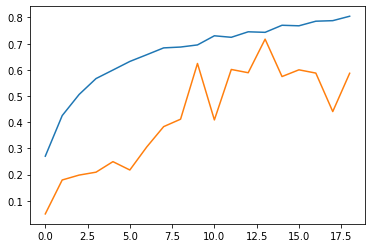

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

Unfortunately, this is still not looking good. The accuracy reached a maximum of 0.71, which is barely better than the one from our benchmark model.

## Train models with bigger dataset

At this point we are going to repeat the dataset creation steps, but this time bring the number of samples of each class at approximately the median size, or 1400 samples, using a combination of undesampling and oversampling.

In [ ]:
cutoff=1400
under_samples={label:
             cutoff+(classes_df['sample_count'].iloc[label]-cutoff)//20 if classes_df['sample_count'].iloc[label]>cutoff
             else classes_df['sample_count'].iloc[label]
             for label in classes_df.index}

over_samples={label:
             cutoff-(cutoff-under_samples[label])//20 if under_samples[label]<cutoff
             else under_samples[label]
             for label in under_samples}

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy=under_samples, random_state=1020034)
undersampled_images, undersampled_labels = undersampler.fit_resample(np.array(images).reshape(-1,1),np.array(labels))

oversampler = RandomOverSampler(sampling_strategy=over_samples, random_state=1020034)
balanced_images, balanced_labels = oversampler.fit_resample(undersampled_images.reshape(-1,1),undersampled_labels)

In [ ]:
[(i, balanced_labels.tolist().count([1 if j==i else 0 for j in range(len(class_names))])) for i in over_samples]

[(0, 1362),
 (1, 1601),
 (2, 1420),
 (3, 1344),
 (4, 1356),
 (5, 1390),
 (6, 1430),
 (7, 1400),
 (8, 1605),
 (9, 1475),
 (10, 1378),
 (11, 1384),
 (12, 1386),
 (13, 1380),
 (14, 1474),
 (15, 1418),
 (16, 1413),
 (17, 1400),
 (18, 1597),
 (19, 1349),
 (20, 2084)]

In [ ]:
train_val_full_images, test_full_images, train_val_full_labels, test_full_labels = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=1020034, stratify=balanced_labels)

First we will train a model based on the hyperparameter values we got from the Bayesian search:

In [ ]:
def kfold(k, batch_size, epochs):
    kf = KFold(n_splits=k)

    k_history=list()

    fold=1
    for train_index, val_index in kf.split(train_val_full_images, train_val_full_labels):
        print(f'Starting Fold {fold}...')
        fold+=1

        train_ds=tf.data.Dataset.from_tensor_slices((train_val_full_images[train_index],train_val_full_labels[train_index]))
        val_ds=tf.data.Dataset.from_tensor_slices((train_val_full_images[val_index],train_val_full_labels[val_index]))
        train_ds=prepare_dataset(train_ds)
        val_ds=prepare_dataset(val_ds)

        model=tuner.hypermodel.build(tuned_hp)
        history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], verbose=0)
        k_history.append(history)

    return k_history

In [ ]:
%%time
big_history=kfold(3, 128, 15)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
CPU times: user 9min 35s, sys: 1min 17s, total: 10min 52s
Wall time: 7min 18s


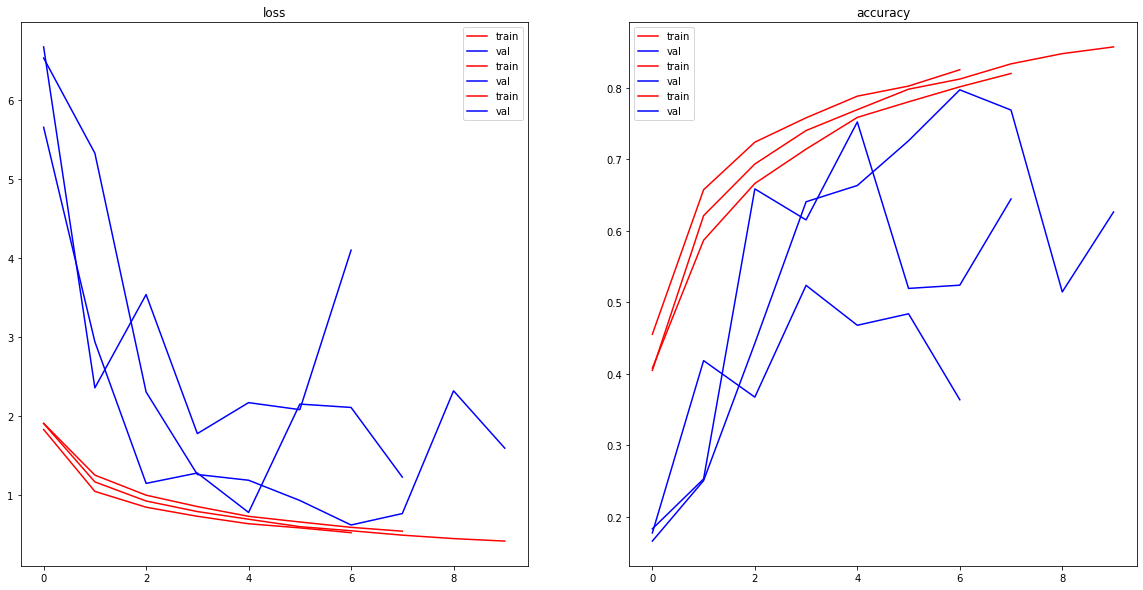

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
for i in range(3):
    plt.plot(big_history[i].history['loss'], color='r', label='train')
    plt.plot(big_history[i].history['val_loss'], color='b', label='val')
plt.title('loss')
plt.legend()
plt.subplot(122)
for i in range(3):
    plt.plot(big_history[i].history['accuracy'], color='r', label='train')
    plt.plot(big_history[i].history['val_accuracy'], color='b', label='val')
plt.title('accuracy')
plt.legend()

And we will also use the biger dataset to train the model we used a benchmark:

In [ ]:
def kfold(k, batch_size, epochs):
    kf = KFold(n_splits=k)

    k_history=list()

    fold=1
    for train_index, val_index in kf.split(train_val_full_images, train_val_full_labels):
        print(f'Starting Fold {fold}...')
        fold+=1

        train_ds=tf.data.Dataset.from_tensor_slices((train_val_full_images[train_index],train_val_full_labels[train_index]))
        val_ds=tf.data.Dataset.from_tensor_slices((train_val_full_images[val_index],train_val_full_labels[val_index]))
        train_ds=prepare_dataset(train_ds)
        val_ds=prepare_dataset(val_ds)

        #model=tuner.hypermodel.build(tuned_hp)
        model=create_benchmark_model()

        model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC()])
        history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], verbose=0)
        k_history.append(history)

    return k_history

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.005, patience=5, restore_best_weights=True)

In [ ]:
%%time
full_history=kfold(3, 128, 50)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
CPU times: user 25min 50s, sys: 4min 28s, total: 30min 19s
Wall time: 21min 30s


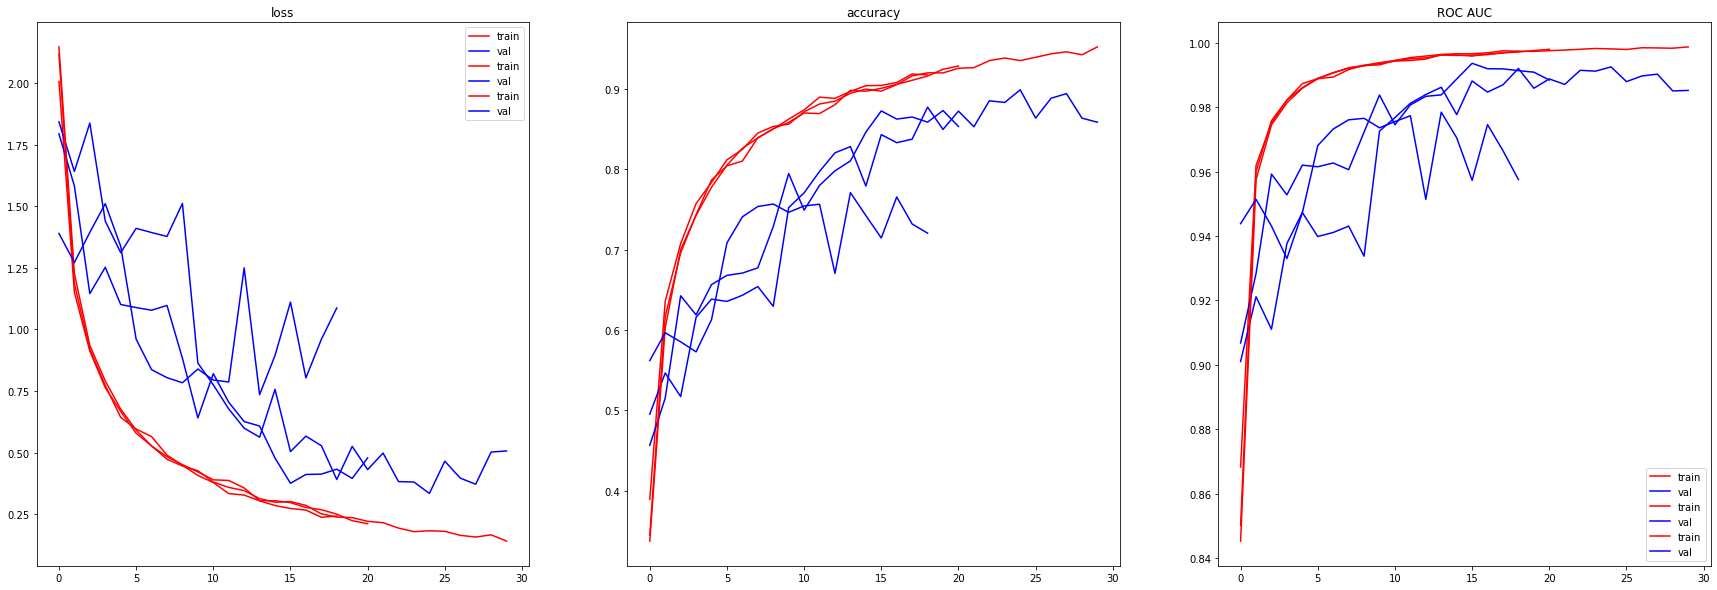

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
for i in range(3):
    plt.plot(full_history[i].history['loss'], color='r', label='train')
    plt.plot(full_history[i].history['val_loss'], color='b', label='val')
plt.title('loss')
plt.legend()
plt.subplot(132)
for i in range(3):
    plt.plot(full_history[i].history['accuracy'], color='r', label='train')
    plt.plot(full_history[i].history['val_accuracy'], color='b', label='val')
plt.title('accuracy')
plt.subplot(133)
for i in range(3):
    plt.plot(full_history[i].history[f'auc_{i+2}'], color='r', label='train')
    plt.plot(full_history[i].history[f'val_auc_{i+2}'], color='b', label='val')
plt.title('ROC AUC')
plt.legend()

# Transfer learning

Finally, we will employ transfer learning by using a pretrained model and modifying its output to apply it on our problem. EfficientNetB4 was chosen due to having a good ratio of accuracy over model size compared to other models in [Keras Applications](https://keras.io/api/applications/).

In [ ]:
train_full_images, val_full_images, train_full_labels, val_full_labels = train_test_split(train_val_full_images, train_val_full_labels, test_size=0.25, random_state=1020034, stratify=train_val_full_labels)
train_ds=tf.data.Dataset.from_tensor_slices((train_full_images,train_full_labels))
val_ds=tf.data.Dataset.from_tensor_slices((val_full_images,val_full_labels))
train_ds=prepare_dataset(train_ds)
val_ds=prepare_dataset(val_ds)

Our initial modification will be minimal, we will strip away the top layer and replace it with one meant to predict our classes. Then we will freeze all layers but the one we added to keep the model's ability to extract features intact.

In [ ]:
base_model = EfficientNetB4(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
144/144 [==============================] - 196s 967ms/step - loss: 0.4217 - accuracy: 0.8651 - auc: 0.9945 - val_loss: 0.2537 - val_accuracy: 0.9139 - val_auc: 0.9981
Epoch 2/10
144/144 [==============================] - 136s 947ms/step - loss: 0.2208 - accuracy: 0.9272 - auc: 0.9983 - val_loss: 0.1749 - val_accuracy: 0.9395 - val_auc: 0.9988
Epoch 3/10
144/144 [==============================] - 136s 948ms/step - loss: 0.1677 - accuracy: 0.9435 - auc: 0.9989 - val_loss: 0.1561 - val_accuracy: 0.9488 - val_auc: 0.9989
Epoch 4/10
144/144 [==============================] - 136s 948ms/step - loss: 0.1283 - accuracy: 0.9579 - auc: 0.9993 - val_loss: 0.1406 - val_accuracy: 0.9546 - val_auc: 0.9984
Epoch 5/10
144/144 [==============================] - 136s 947ms/step - loss: 0.1088 - accuracy: 0.9650 - auc: 0.9995 - val_loss: 0.1330 - val_accuracy: 0.9535 - val_auc: 0.9989
Epoch 6/10
144/144 [==============================] - 136s 946ms/step - loss: 0.0980 - accuracy: 0.9668 - auc:

The results here are of course much better than the ones from any of our custom models.

In [ ]:
history.history

{'accuracy': [0.865067720413208,
  0.927176833152771,
  0.9434927105903625,
  0.9579050540924072,
  0.9650296568870544,
  0.9667699933052063,
  0.9687278866767883,
  0.9703595042228699,
  0.9756893515586853],
 'auc': [0.9945383071899414,
  0.9982669353485107,
  0.9989137649536133,
  0.9993306994438171,
  0.999480128288269,
  0.999298095703125,
  0.9995154142379761,
  0.999525249004364,
  0.9995290637016296],
 'loss': [0.4216611981391907,
  0.2207564413547516,
  0.16774873435497284,
  0.1283329576253891,
  0.10875415802001953,
  0.09796142578125,
  0.09020769596099854,
  0.0822676569223404,
  0.0726071149110794],
 'val_accuracy': [0.9138521552085876,
  0.9394680857658386,
  0.948768138885498,
  0.9546418786048889,
  0.9534997344017029,
  0.9572523832321167,
  0.9580681920051575,
  0.9548050165176392,
  0.9536629319190979],
 'val_auc': [0.9981161952018738,
  0.9987638592720032,
  0.9988882541656494,
  0.9983558058738708,
  0.9988917112350464,
  0.9989630579948425,
  0.998526394367218,
  

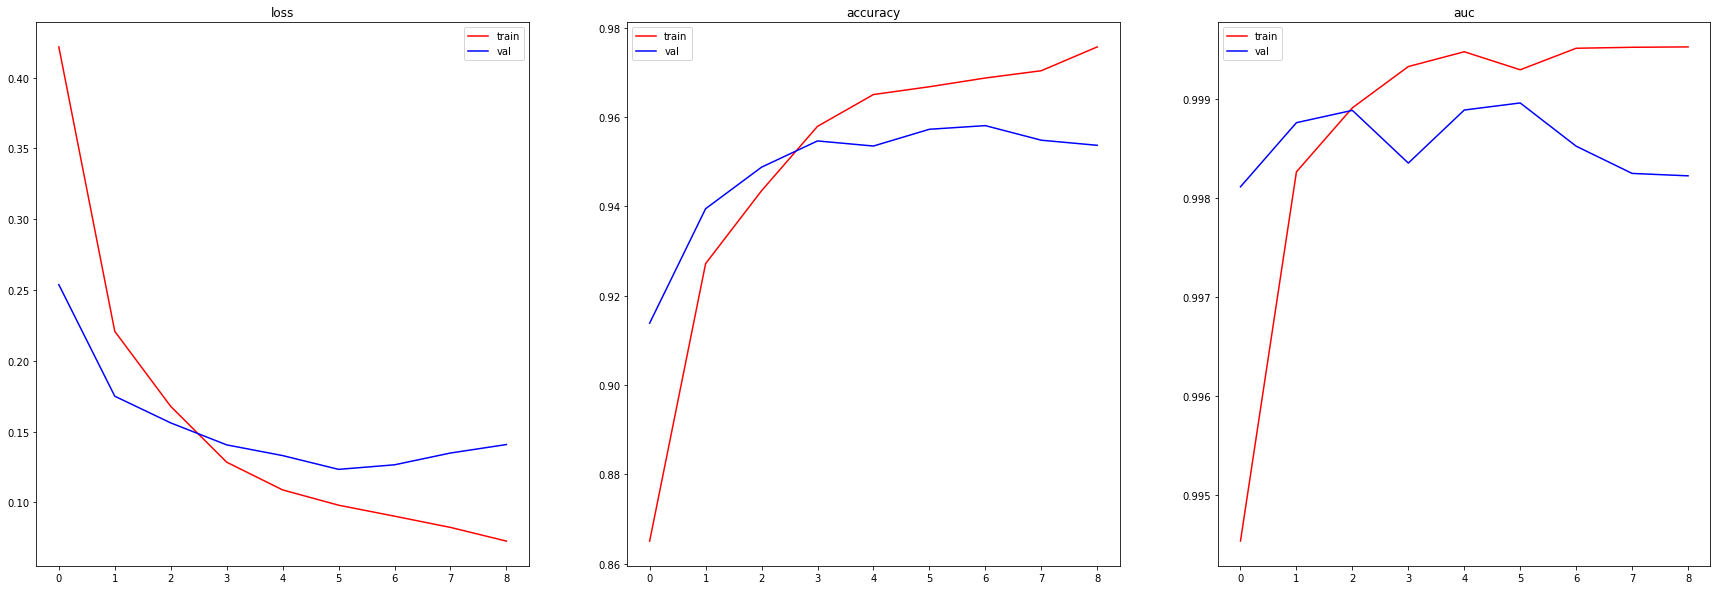

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history.history['loss'], color='r', label='train')
plt.plot(history.history['val_loss'], color='b', label='val')
plt.title('loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], color='r', label='train')
plt.plot(history.history['val_accuracy'], color='b', label='val')
plt.title('accuracy')
plt.legend()
plt.subplot(133)
plt.plot(history.history['auc'], color='r', label='train')
plt.plot(history.history['val_auc'], color='b', label='val')
plt.title('auc')
plt.legend()

As a final assessment of this model's performance, we will use it to predict the labels of the test set we had left aside and compile a report of metrics for each class.

In [ ]:
test_ds=tf.data.Dataset.from_tensor_slices((test_full_images,test_full_labels))
test_ds=prepare_dataset(test_ds)
pred=model.predict(test_ds)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.apply_along_axis(np.argmax,1,test_full_labels), np.apply_along_axis(np.argmax,1,pred)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       272
           1       0.94      0.95      0.95       320
           2       0.99      0.96      0.97       284
           3       1.00      1.00      1.00       269
           4       0.95      0.93      0.94       271
           5       1.00      1.00      1.00       278
           6       0.92      0.89      0.90       286
           7       0.97      1.00      0.98       280
           8       0.99      1.00      0.99       321
           9       0.98      0.88      0.93       295
          10       0.99      0.96      0.98       276
          11       1.00      0.98      0.99       277
          12       1.00      0.99      0.99       277
          13       0.93      0.95      0.94       276
          14       1.00      0.98      0.99       295
          15       0.89      0.96      0.92       284
          16       0.91      0.97      0.94       283
          17       0.95    